In [207]:
import re
import pandas as pd
import numpy as np # numpy incompatability issue debugged.
from arch.unitroot import ADF
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

%matplotlib inline

In [2]:
print (np.version.version)

1.16.0


# Create PairTrading Class

In [161]:
class PairTrading:
    def SSD(self, priceX, priceY):
        if priceX is None or priceY is None:
            print("Error: Missing Price Series!")
        returnX=(priceX-priceX.shift(1))/priceX.shift(1)[1:]
        returnY=(priceY - priceY.shift(1))/priceY.shift(1)[1:]
        standardX=(returnX+1).cumprod()
        standardY=(returnY+1).cumprod()
        SSD=np.sum((standardY-standardX)**2)
        return SSD
    
    def SSDSpread(self, priceX, priceY):
        if priceX is None or priceY is None:
            print("Error: Missing Price Series!")
        returnX=(priceX-priceX.shift(1))/priceX.shift(1)[1:]
        returnY=(priceY - priceY.shift(1))/priceY.shift(1)[1:]
        standardX=(returnX+1).cumprod()
        standardY=(returnY+1).cumprod()
        spread=standardY-standardX
        return spread
    
    def cointegration(self, priceX, priceY):
        if priceX is None or priceY is None:
            print("Error: Missing Price Series!")
        priceX=np.log(priceX)
        priceY=np.log(priceY)
        results=sm.OLS(priceY,sm.add_constant(priceX)).fit()
        resid=results.resid
        adfSpread=ADF(resid)
        if adfSpread.pvalue>=0.05:
            print("""No Cointegration.
                  P-value of ADF test: {};
                  Coefficients of regression:
                  Intercept: {};
                  Beta: {}
                  """.format(adfSpread.pvalue, results.params[0], results.params[1]))
            return None
        else:
            print("""Cointegration Tested!
                  P-value of ADF test: {};
                  Coefficients of regression:
                  Intercept: {};
                  Beta: {}
                  """.format(adfSpread.pvalue, results.params[0], results.params[1]))
            return results.params[0], results.params[1]
        
    def CointegrationSpread(self, priceX, priceY, formPeriod, tradePeriod):
        if priceX is None or priceY is None:
            print("Missing Price Series!")
#         if not (re.fullmatch("\d{4}-\d{2}-d\{2}:\d{4}-\d{2}-\d{2}", formPeriod)
#                 or re.fullmatch("\d{4}-\d{2}-d\{2}:\d{4}-\d{2}-\d{2}", tradePeriod)):
#             print("Error: formPeriod or tradePeriod data format issues!")
        formX=priceX[formPeriod.split(":")[0]:formPeriod.split(":")[1]]
        formY=priceY[formPeriod.split(":")[0]:formPeriod.split(":")[1]]
        coefficients=self.cointegration(formX, formY)
        if coefficients is None:
            print("No cointegrations, unable to match!")
        else:
            spread=(np.log(priceY[tradePeriod.split(":")[0]:tradePeriod.split(":")[1]])
                    -coefficients[0]-coefficients[1]*np.log(priceX[tradePeriod.split(":")[0]:
                    tradePeriod.split(":")[1]]))
            return spread
        
    def calBound(self, priceX, priceY, method, formPeriod, width=1.5):
#         if not (re.fullmatch("\d{4}-\d{2}-d\{2}:\d{4}-\d{2}-\d{2}", formPeriod)
#                 or re.fullmatch("\d{4}-\d{2}-d\{2}:\d{4}-\d{2}-\d{2}", tradePeriod)):
#             print("Error: formPeriod or tradePeriod data format issues!")
        if method=="SSD":
            spread=self.SSDspread(priceX[formPeriod.split(":")[0]:
                                         formPeriod.split(":")[1]],
                                  priceY[formPeriod.split(":")[0]:
                                         formPeriod.split(":")[1]])
            mu=np.mean(spread)
            sd=np.std(spread)
            UpperBound=mu+width*sd
            LowerBound=mu-width*sd
            return UpperBound, LowerBound
        elif method=="Cointegration":
            spread=self.CointegrationSpread(priceX, priceY, formPeriod, formPeriod)
            mu=np.mean(spread)
            sd=np.std(spread)
            UpperBound=mu+width*sd
            LowerBound=mu-width*sd
            return UpperBound, LowerBound            
        else:
            print("No such method, please choose either 'SSD' or 'Cointegration'!")

In [127]:
path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/极宽/zwPython2019m1量化AI优化版/TQDat/day/stk/"

In [137]:
priceA = pd.read_csv(path+"601988.csv")
priceB = pd.read_csv(path+"600000.csv")

priceA['date'] = pd.to_datetime(priceA['date'])
priceA['date'] = priceA['date'].astype(str)

priceB['date'] = pd.to_datetime(priceB['date'])
priceB['date'] = priceB['date'].astype(str)

In [139]:
priceA = priceA.sort_values("date")
priceA.index = priceA['date']
priceB = priceB.sort_values("date")
priceB.index = priceB['date']

In [140]:
formPeriod = "2014-01-01:2015-01-01"
tradePeriod = "2015-01-01:2015-06-30"
priceAf=priceA[formPeriod.split(":")[0]:formPeriod.split(":")[1]]
priceBf=priceB[formPeriod.split(":")[0]:formPeriod.split(":")[1]]
priceAt=priceA[tradePeriod.split(":")[0]:tradePeriod.split(":")[1]]
priceBt=priceB[tradePeriod.split(":")[0]:tradePeriod.split(":")[1]]

In [141]:
price_col = "close"

In [142]:
priceAf=priceAf[price_col]
priceBf=priceBf[price_col]
priceAt=priceAt[price_col]
priceBt=priceBt[price_col]

In [162]:
pt=PairTrading()

In [144]:
# SSD:
SSD=pt.SSD(priceAf,priceBf)
SSD

0.46261904765024103

In [145]:
# 
SSDspread=pt.SSDSpread(priceAf, priceBf)
SSDspread.describe()

count    243.000000
mean       0.019143
std        0.039290
min       -0.044968
25%       -0.011097
50%        0.009971
75%        0.041477
max        0.168541
Name: close, dtype: float64

In [146]:
SSDspread.head()

date
2014-01-02         NaN
2014-01-03   -0.001616
2014-01-06    0.015250
2014-01-07    0.013784
2014-01-08    0.024287
Name: close, dtype: float64

In [147]:
len(priceAf)

244

In [148]:
len(priceBf)

244

In [149]:
diff_dates = set(list(priceAf.index)) - set(list(priceBf.index))
diff_dates

set()

In [150]:
coefficients=pt.cointegration(priceAf, priceBf) 

Cointegration Tested!
                  P-value of ADF test: 0.02326844054339974;
                  Coefficients of regression:
                  Intercept: 0.9769838748986963;
                  Beta: 1.0590794869512083
                  


In [151]:
coefficients

(0.9769838748986963, 1.0590794869512083)

In [153]:
priceA

,date,open,high,low,close,volume
date,,,,,,
2006-07-05,2006-07-05,2.316,2.350,2.182,2.200,17639020.19
2006-07-06,2006-07-06,2.176,2.182,2.142,2.159,3725565.48
2006-07-07,2006-07-07,2.159,2.165,2.124,2.136,2097985.56
2006-07-10,2006-07-10,2.136,2.159,2.124,2.147,1127236.15
2006-07-11,2006-07-11,2.153,2.194,2.130,2.176,1356450.50
2006-07-12,2006-07-12,2.171,2.171,2.147,2.147,1007250.25
2006-07-13,2006-07-13,2.147,2.147,2.084,2.089,2589898.32
2006-07-14,2006-07-14,2.072,2.107,2.060,2.084,1189663.31
2006-07-17,2006-07-17,2.078,2.084,2.060,2.078,674959.33


In [155]:
priceA=priceA['close']
priceB=priceB['close']

In [156]:
CoSpreadF=pt.CointegrationSpread(priceA,priceB,formPeriod,formPeriod)

Error: formPeriod or tradePeriod data format issues!
Cointegration Tested!
                  P-value of ADF test: 0.02326844054339974;
                  Coefficients of regression:
                  Intercept: 0.9769838748986963;
                  Beta: 1.0590794869512083
                  


In [157]:
CoSpreadF.describe()

count    2.440000e+02
mean    -3.763383e-15
std      3.062290e-02
min     -6.137529e-02
25%     -2.618225e-02
50%     -4.440957e-03
75%      2.429209e-02
max      8.023265e-02
Name: close, dtype: float64

In [163]:
bound=pt.calBound(priceA, priceB, 'Cointegration', formPeriod, width = 1.2)

Cointegration Tested!
                  P-value of ADF test: 0.02326844054339974;
                  Coefficients of regression:
                  Intercept: 0.9769838748986963;
                  Beta: 1.0590794869512083
                  


In [165]:
bound

(0.036672103363837236, -0.03667210336384476)

# Python实测配对交易交易策略

In [168]:
formStart = "2014-01-01"
formEnd = "2015-01-01"

PA = priceA.copy()
PB = priceB.copy()

PAf = priceA[formStart:formEnd]
PBf = priceB[formStart:formEnd]

In [171]:
# 中国银行一阶协整关系检验：

log_PAf=np.log(PAf)
adfA=ADF(log_PAf)
print(adfA.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                  3.397
P-value                         1.000
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [172]:
adfAd=ADF(log_PAf.diff()[1:])
print(adfAd.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.864
P-value                         0.050
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


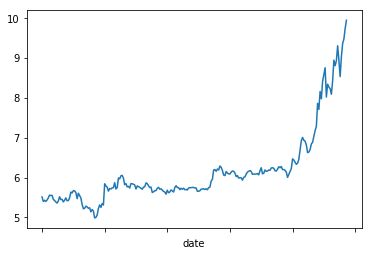

In [175]:
PBf.plot()

In [176]:
# 浦发银行一阶单整检验
log_PBf=np.log(PBf)
adfB=ADF(log_PBf)
print(adfB.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                  2.362
P-value                         0.999
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


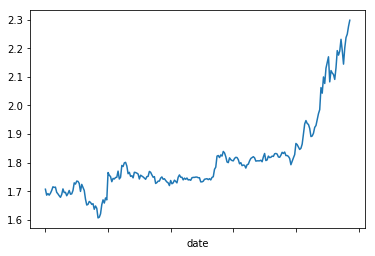

In [177]:
log_PBf.plot()

In [182]:
adfBd=ADF(log_PBf.diff()[1:])
print(adfBd.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -3.842
P-value                         0.003
Lags                               11
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [185]:
# 协整关系检验：
model=sm.OLS(log_PBf,sm.add_constant(log_PAf)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  close   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     4438.
Date:                Sun, 21 Jul 2019   Prob (F-statistic):          1.14e-157
Time:                        15:57:22   Log-Likelihood:                 504.87
No. Observations:                 244   AIC:                            -1006.
Df Residuals:                     242   BIC:                            -998.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9770      0.013     77.531      0.000       0.952       1.002
close          1.0591      0.016     66.622      0.000       1.028       1.090
==============================================================================
Omnibus:                       20.816   Durbin-Watson:                   0.158
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.738
Skew:                           0.451   Prob(JB):                      0.00104
Kurtosis:                       2.267   Cond. No.                         13.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [186]:
alpha=model.params[0]
alpha

0.9769838748986963

In [187]:
beta=model.params[1]
beta

1.0590794869512083

In [214]:
# 残差单位根检验
spreadf=log_PBf-beta*log_PAf-alpha
adfSpread=ADF(spreadf)
print(adfSpread.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -3.147
P-value                         0.023
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [215]:
mu=np.mean(spreadf)
sd=np.std(spreadf)

In [216]:
spreadf

date
2014-01-02   -0.010653
2014-01-03   -0.011176
2014-01-06    0.006769
2014-01-07    0.005580
2014-01-08    0.016590
2014-01-09    0.030676
2014-01-10    0.047378
2014-01-13    0.032613
2014-01-14    0.038061
2014-01-15    0.019895
2014-01-16    0.018766
2014-01-17    0.020566
2014-01-20    0.019422
2014-01-21    0.029262
2014-01-22    0.031741
2014-01-23    0.031452
2014-01-24    0.028133
2014-01-27    0.020566
2014-01-28    0.023724
2014-01-29    0.017574
2014-01-30    0.013274
2014-02-07    0.022618
2014-02-10    0.026291
2014-02-11    0.036068
2014-02-12    0.036118
2014-02-13    0.042257
2014-02-14    0.045515
2014-02-17    0.033937
2014-02-18    0.010499
2014-02-19   -0.002134
                ...   
2014-11-20   -0.013755
2014-11-21   -0.003936
2014-11-24    0.006365
2014-11-25    0.015708
2014-11-26    0.008749
2014-11-27    0.012466
2014-11-28    0.006781
2014-12-01   -0.028301
2014-12-02   -0.026674
2014-12-03   -0.003776
2014-12-04    0.012951
2014-12-05   -0.014572
2014-1

In [217]:
# 设定交易期
tradeStart="2015-01-01"
tradeEnd="2015-06-30"

PAt=PA[tradeStart:tradeEnd]
PBt=PB[tradeStart:tradeEnd]

In [218]:
CoSpreadT=np.log(PBt)-beta*np.log(PAt)-alpha
CoSpreadT.describe()

count    112.000000
mean      -0.034960
std        0.053322
min       -0.161528
25%       -0.061236
50%       -0.030105
75%        0.004538
max        0.059826
Name: close, dtype: float64

In [219]:
CoSpreadT.dropna(inplace=True)

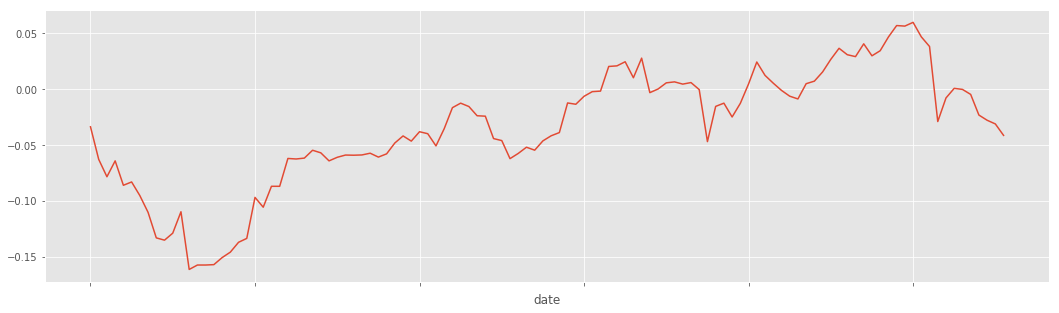

In [220]:
CoSpreadT.plot(figsize=(18, 5))

In [221]:
mu

-3.763383047817488e-15

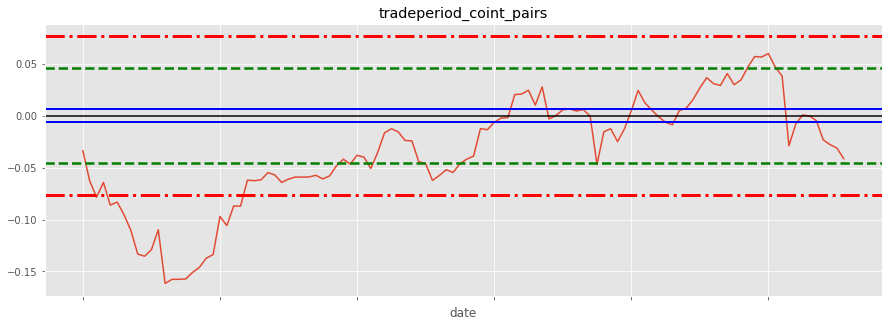

In [226]:
CoSpreadT.plot(figsize=(15,5))
plt.title("tradeperiod_coint_pairs")
plt.axhline(y=mu,color='black')
plt.axhline(y=mu+0.2*sd,color='blue',ls='-',lw=2)
plt.axhline(y=mu-0.2*sd,color='blue',ls='-',lw=2)
plt.axhline(y=mu+1.5*sd,color='green',ls='--',lw=2.5)
plt.axhline(y=mu-1.5*sd,color='green',ls='--',lw=2.5)
plt.axhline(y=mu+2.5*sd,color='red',ls='-.',lw=3)
plt.axhline(y=mu-2.5*sd,color='red',ls='-.',lw=3)